In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor

np.random.seed(666)

## Load & investigate the DFs, create the time stamp columns

In [2]:
train = pd.read_csv('train.csv', parse_dates=True)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [4]:
train['datetime'] = pd.to_datetime(train['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [6]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day']= train['datetime'].dt.day
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1


datetime - hourly date + timestamp

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather 

          1: Clear, Few clouds, Partly cloudy, Partly cloudy
          
          2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
          
          3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
          
          4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [7]:
round(train.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.51,1.12,1.00,2.00,3.00,4.00,4.00
holiday,10886.0,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,10886.0,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,10886.0,1.42,0.63,1.00,1.00,1.00,2.00,4.00
temp,10886.0,20.23,7.79,0.82,13.94,20.50,26.24,41.00
atemp,10886.0,23.66,8.47,0.76,16.66,24.24,31.06,45.46
humidity,10886.0,61.89,19.25,0.00,47.00,62.00,77.00,100.00
windspeed,10886.0,12.80,8.16,0.00,7.00,13.00,17.00,57.00
casual,10886.0,36.02,49.96,0.00,4.00,17.00,49.00,367.00
registered,10886.0,155.55,151.04,0.00,36.00,118.00,222.00,886.00


In [8]:
test = pd.read_csv('test.csv', parse_dates=True)
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [9]:
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day']= test['datetime'].dt.day
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20


In [10]:
round(test.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
season,6493.0,2.49,1.09,1.00,2.00,3.00,3.00,4.00
holiday,6493.0,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,6493.0,0.69,0.46,0.00,0.00,1.00,1.00,1.00
weather,6493.0,1.44,0.65,1.00,1.00,1.00,2.00,4.00
temp,6493.0,20.62,8.06,0.82,13.94,21.32,27.06,40.18
atemp,6493.0,24.01,8.78,0.00,16.66,25.00,31.06,50.00
humidity,6493.0,64.13,19.29,16.00,49.00,65.00,81.00,100.00
windspeed,6493.0,12.63,8.25,0.00,7.00,11.00,17.00,56.00
year,6493.0,2011.50,0.50,2011.00,2011.00,2012.00,2012.00,2012.00
month,6493.0,6.57,3.43,1.00,4.00,7.00,10.00,12.00


#### No NaNs in either of the train, test DFs

## Some visual inspection

<AxesSubplot:>

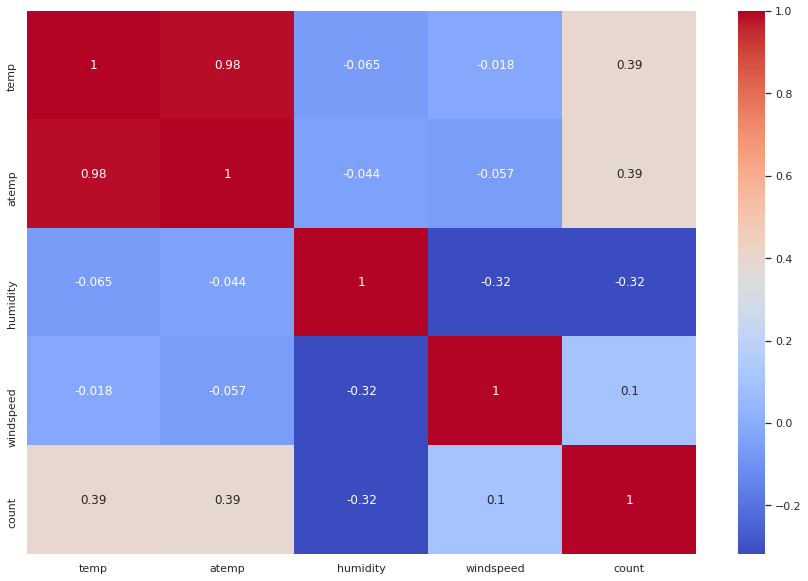

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(train[['temp','atemp','humidity','windspeed','count']].corr(), annot=True, cmap='coolwarm')

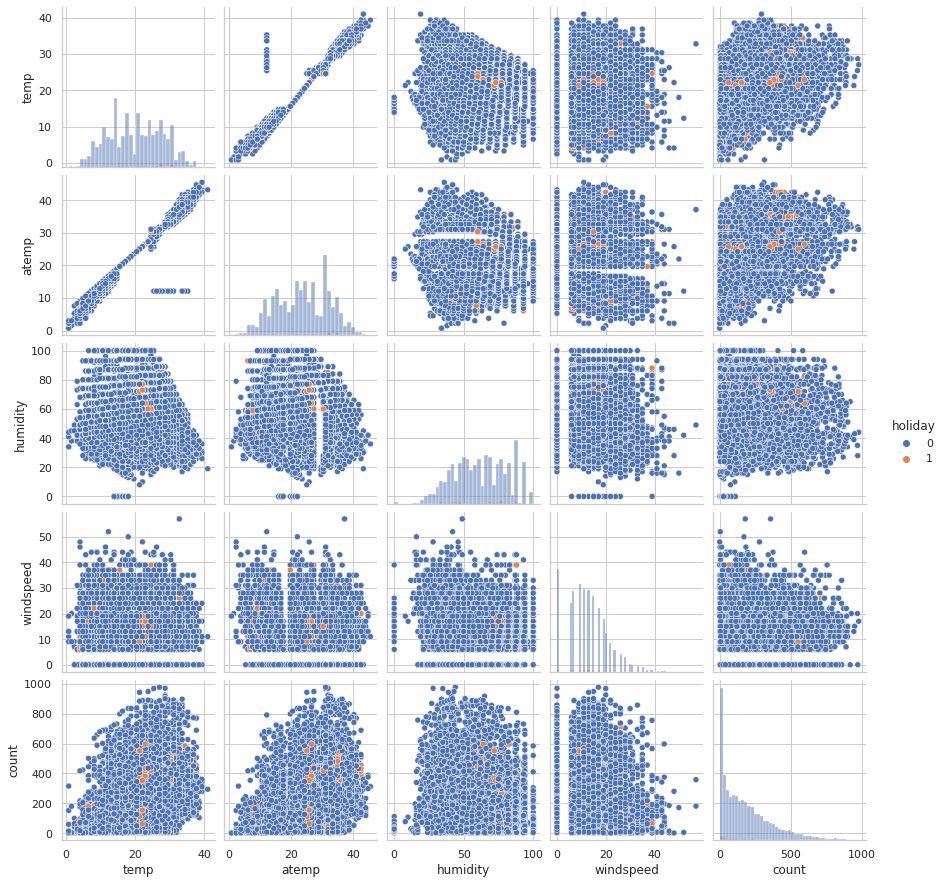

In [12]:
sns.pairplot(train[['holiday', 'temp','atemp','humidity','windspeed','count']], hue="holiday", diag_kind="hist");

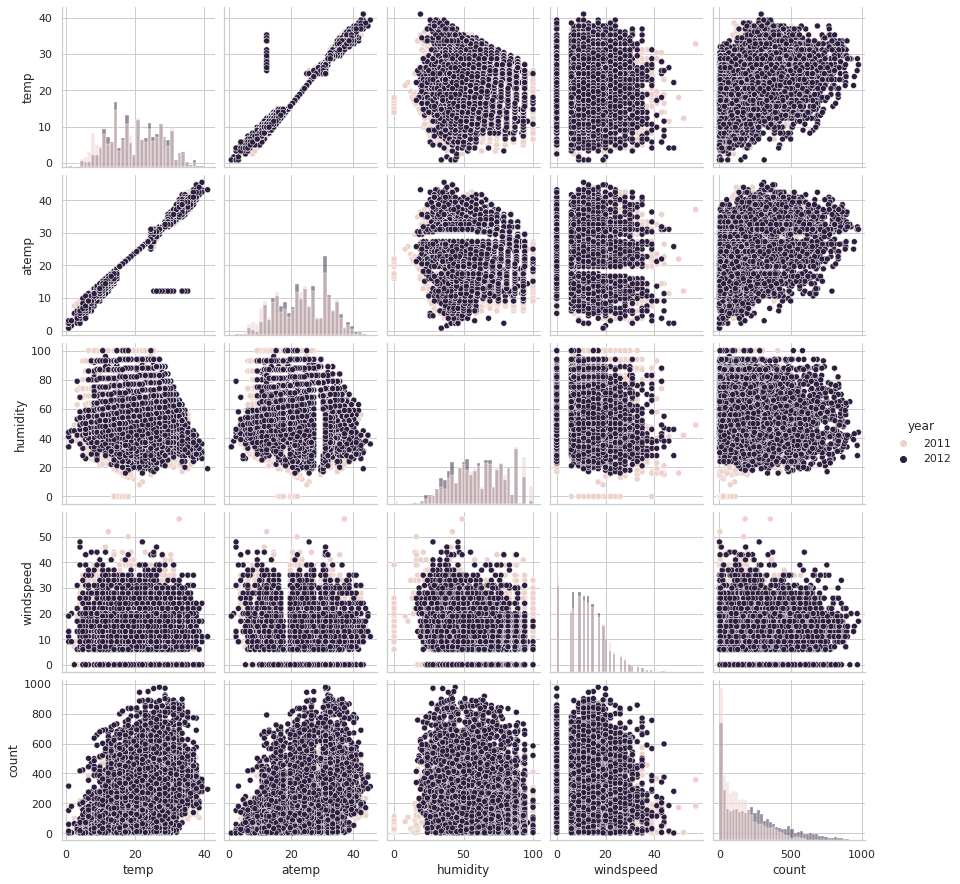

In [13]:
sns.pairplot(train[['year', 'temp','atemp','humidity','windspeed','count']], hue="year", diag_kind="hist");

<AxesSubplot:>

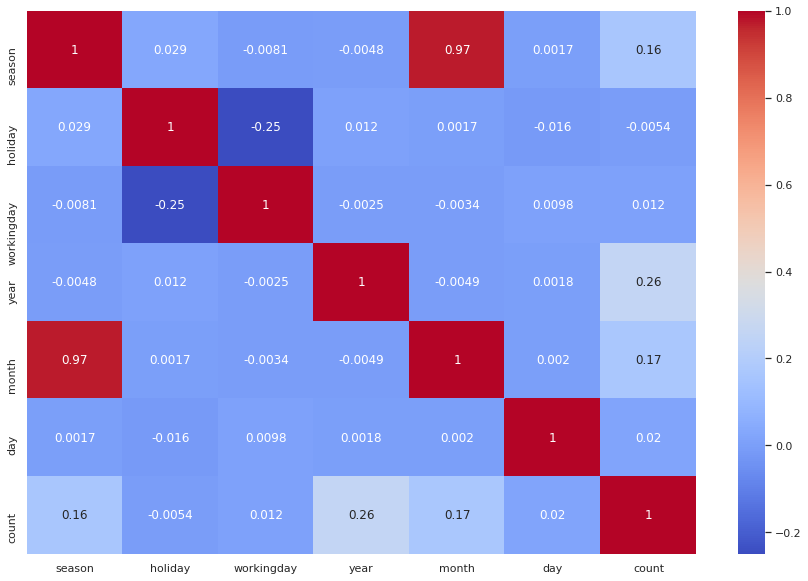

In [14]:
plt.figure(figsize=(15,10))
sns.heatmap(train[['season', 'holiday','workingday','year','month', 'day', 'count']].corr(), annot=True, cmap='coolwarm')

### Start the train test split for train.csv & the pipeline

In [15]:
X = train.drop(columns=['datetime', 'season', 'temp', 'casual', 'registered', 'count', 'holiday'])
y = train['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8164, 8), (2722, 8), (8164,), (2722,))

In [16]:
# X_train.columns
# 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day'
cols_2b_scaled = ['workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day']
cols_2b_scaled_pipeline = Pipeline([('normalize', MinMaxScaler())])

In [17]:
feature_engineering = ColumnTransformer([('normalize_all_cols', cols_2b_scaled_pipeline, cols_2b_scaled)])

In [18]:
feature_engineering.fit(X_train)

ColumnTransformer(transformers=[('normalize_all_cols',
                                 Pipeline(steps=[('normalize',
                                                  MinMaxScaler())]),
                                 ['workingday', 'weather', 'atemp', 'humidity',
                                  'windspeed', 'year', 'month', 'day'])])

In [19]:
X_train_fe = feature_engineering.fit_transform(X_train)
X_train_fe
X_train_fe.shape

(8164, 8)

In [20]:
X_train_fe = pd.DataFrame(feature_engineering.fit_transform(X_train),
                          columns=['workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day'])
X_train_fe.head()

,workingday,weather,atemp,humidity,windspeed,year,month,day
0,1.0,0.333333,0.569022,0.83,0.00000,1.0,0.818182,0.944444
1,1.0,0.000000,0.189598,0.36,0.00000,0.0,0.090909,0.444444
2,0.0,0.000000,0.586207,0.30,0.52639,0.0,0.272727,0.888889
3,1.0,0.000000,0.603505,0.46,0.00000,1.0,0.818182,0.000000
4,1.0,0.333333,0.517241,0.67,0.00000,0.0,0.272727,1.000000


In [21]:
random_forest_regressor = RandomForestRegressor()
random_forest_regressor.fit(X_train_fe, y_train)
random_forest_regressor.feature_importances_

array([0.02807522, 0.03486413, 0.29314391, 0.21552182, 0.13953852,
       0.07058827, 0.09588243, 0.12238572])

In [22]:
rec_fe_elm = RFE(random_forest_regressor)
rec_fe_elm.fit(X_train_fe, y_train)
rec_fe_elm.support_

array([False, False,  True,  True,  True, False, False,  True])

In [23]:
rec_fe_elm.ranking_

array([5, 4, 1, 1, 1, 3, 2, 1])

In [24]:
rfecv = RFECV(estimator=random_forest_regressor, step=1, cv=StratifiedKFold(10))
rfecv.fit(X_train_fe, y_train)
print('Optimal number of features: {}'.format(rfecv.n_features_))

/home/mmuratardag/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Optimal number of features: 8


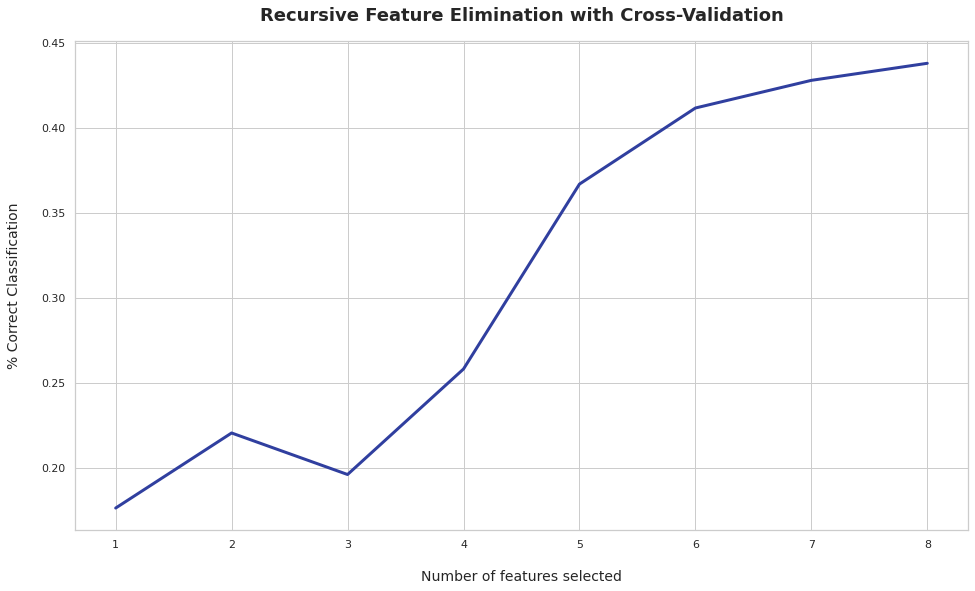

In [25]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

In [26]:
rfecv.estimator_.feature_importances_

array([0.02845823, 0.03454831, 0.29270331, 0.21745239, 0.13664259,
       0.07063419, 0.09797925, 0.12158172])

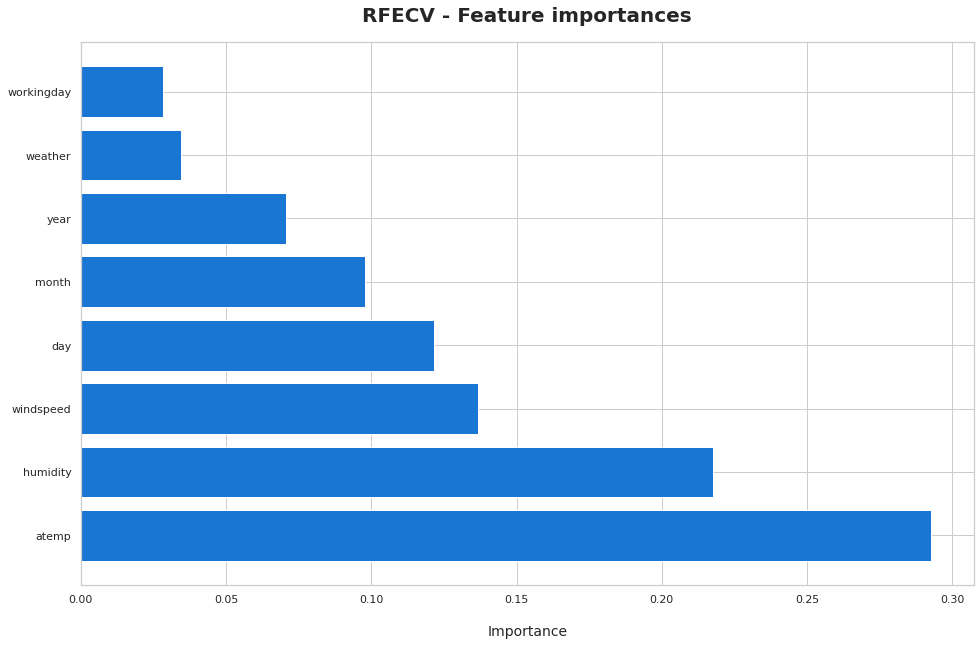

In [27]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 10))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

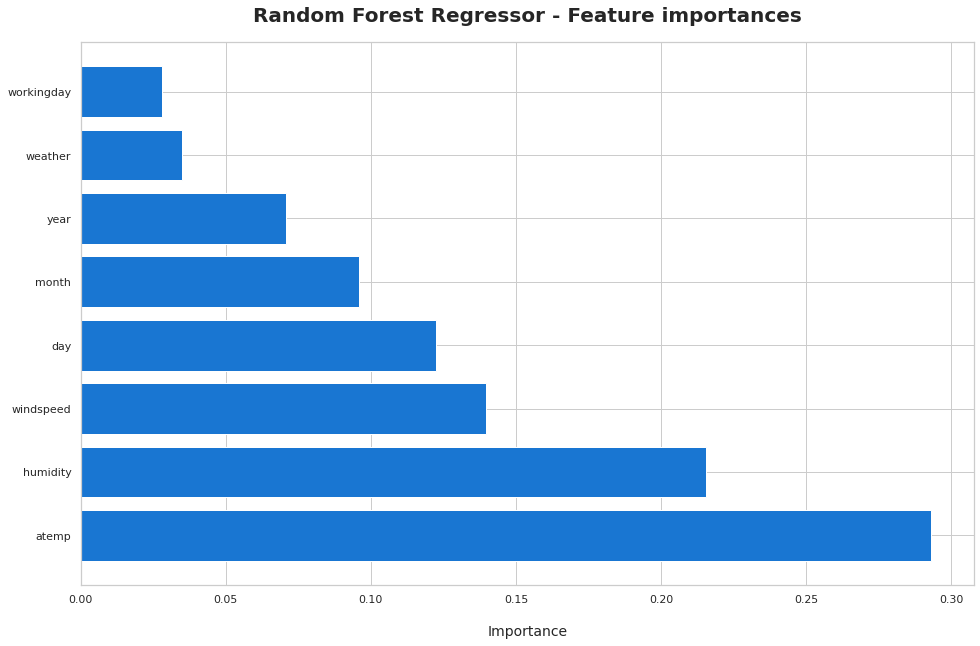

In [28]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = random_forest_regressor.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 10))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Regressor - Feature importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()